# Section 3: Unsupervised learning – Clustering
In this unsupervised learning task, the objective is to cluster Reddit comments based on the words used
within them. The aim is to identify patterns and group comments with similar words together. 
Note: Use only the column body (i.e. the textual data) to extract the features used in this section, do not
feed “author”, “subreddit” and “created_utc” to the model.


In [7]:
# all required imports
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score


In [9]:
# Load cleaned unsupervised dataset
df_unsup = pd.read_csv("../data/clean_unsupervised.csv")

print(f"Number of comments: {len(df_unsup)}")
df_unsup.head(10)


Number of comments: 1107946


,author,subreddit,created_utc,body,body_normalized,body_clean
0,ejchristian86,TwoXChromosomes,1.388534e+09,I hadn't ever heard of them before joining thi...,i hadn't ever heard of them before joining thi...,hear join subreddit big thing apparently commo...
1,ZenDragon,gaming,1.388534e+09,"At 7680 by 4320 with 64x AA, right?","at 7680 by 4320 with 64x aa, right?",7680 4320 64x aa right
2,savoytruffle,AskReddit,1.388534e+09,bite me,bite me,bite
3,hentercenter,stlouisblues,1.388534e+09,Damn that was a good penalty :(,damn that was a good penalty :(,damn good penalty
4,rick-o-suave,army,1.388534e+09,I swore into DEP on 6-OCT and I left 5-NOV und...,i swore into dep on 6-oct and i left 5-nov und...,swear dep 6 oct leave 5 nov 18x contract month...
5,olivermihoff,AdviceAnimals,1.388534e+09,Not that it's ever to be equated because it's ...,not that it's ever to be equated because it's ...,equate horrible slavery think page make kind s...
6,Cleriesse,AskReddit,1.388534e+09,There is nothing more more erotic to me than p...,there is nothing more more erotic to me than p...,erotic picture rock hard dick mmmmph
7,murderer_of_death,MorbidReality,1.388534e+09,"Soooo, the government and every large bank?","soooo, the government and every large bank?",soooo government large bank
8,SpiralSoul,Pathfinder_RPG,1.388534e+09,I always give both PCs and NPCs/bosses max HP.,i always give both pcs and npcs/bosses max hp.,pc npc boss max hp
9,IRideVelociraptors,FreeEBOOKS,1.388534e+09,"Hi mattyd42, could you provide a link with the...","hi mattyd42, could you provide a link with the...",hi mattyd42 provide link post


In [ ]:
# Informations about the cleaned comments
df_unsup['body_clean'].str.len().describe()


count    1.092674e+06
mean     8.088918e+01
std      1.415220e+02
min      1.000000e+00
25%      2.300000e+01
50%      5.700000e+01
75%      7.500000e+01
max      1.079900e+04
Name: body_clean, dtype: float64

In [ ]:
# to avoid dominance of highly active subreddits, we sample at most N comments per subreddit
def balanced_sampling(dataframe, group_column="subreddit", max_comments = 500, random_state=42):
      return (
        dataframe.groupby(group_column, group_keys=False)
          .apply(lambda x: x.sample(
              n=min(len(x), max_comments),
              random_state=random_state
          ))
    )

df_sample = balanced_sampling(df_unsup, group_column="subreddit", max_comments=500)

print(f"Sampled comments: {len(df_sample)}")
df_sample["subreddit"].value_counts().head()

C:\Users\bonio\AppData\Local\Temp\ipykernel_27924\928491416.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(


Sampled comments: 343114


In [10]:
# Remove empty documents / with missing data 
df_sample = df_sample.dropna(subset=['body_clean'])
df_sample = df_sample[df_sample['body_clean'].str.strip() != ""]
df_sample['body_clean'] = df_sample['body_clean'].astype(str)

print(f"Dimension after cut empty stuff: {len(df_sample)}")


Dimension after cut empty stuff: 337708


### Dimensionality reduction
In this section, we apply unsupervised learning to explore patterns in Reddit comments.
Text data is transformed using TF-IDF, reduced with TruncatedSVD, and clustered using KMeans.  
We removed the custom `token_pattern` to align the TF-IDF configuration
with Section 1, relying on the default scikit-learn tokenization.
This also avoids unintentionally filtering out tokens such as emojis.

In [ ]:
#  TF-IDF Vectorizer using only the cleaned text (it is in body_clean)
tfidf = TfidfVectorizer(
    max_features=10000,
    min_df=10,                  
    max_df=0.4,                
    stop_words='english', 
    ngram_range=(1, 2)          # uni-gram و bi-gram
)
X = tfidf.fit_transform(df_sample['body_clean'])



In [ ]:


n_components = 50
svd = TruncatedSVD(n_components=n_components, random_state=42)
X_reduced = svd.fit_transform(X)
X_reduced.shape


(614192, 50)

In [49]:
from sklearn.cluster import KMeans

k = 10
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_reduced)

labels


array([0, 0, 0, ..., 0, 4, 0], dtype=int32)

In [50]:
df_sample = df_sample.reset_index(drop=True)
df_sample["cluster"] = labels
df_sample.head()


,author,subreddit,created_utc,body,body_normalized,body_clean,cluster
0,DCDVath,1022,1.390343e+09,I just picked one up myself at the gun show 2 ...,i just picked one up myself at the gun show 2 ...,pick gun 2 weekend find 22lr ammo,0
1,razor_edge,1022,1.390578e+09,No problems at all.,no problems at all.,problem,0
2,razor_edge,1022,1.389429e+09,The receiver is the only component classified ...,the receiver is the only component classified ...,receiver component classify gun buy ffl privat...,0
3,razor_edge,1022,1.390617e+09,Eley Tenex and RWS R-50 were the best of the t...,eley tenex and rws r-50 were the best of the t...,eley tenex rws r-50 good target ammo test aver...,0
4,razor_edge,1022,1.390536e+09,A conclusive deduction in an opinion? Wtf are ...,a conclusive deduction in an opinion? wtf are ...,conclusive deduction opinion wtf talk own clea...,0


### Note on anomalous clusters

When inspecting the cluster sizes, we observe that one or two clusters are significantly larger than the others.
By manually checking their content, we found that these clusters are dominated by repeated or near-duplicate comments,
often posted many times by the same user.

These clusters therefore represent anomalous behaviour rather than meaningful semantic topics.
We keep them in the analysis for completeness, but we do not interpret them as genuine discussion themes.


In [51]:
df_sample["cluster"].value_counts().sort_index()


cluster
0    428353
1     28429
2      5000
3      4981
4     66696
5      3728
6     10828
7     46094
8      9352
9     10731
Name: count, dtype: int64

In [52]:
df_sample[df_sample["cluster"] == 0]["body"].head(15)


0     I just picked one up myself at the gun show 2 ...
1                                  No problems at all. 
2     The receiver is the only component classified ...
3     Eley Tenex and RWS R-50 were the best of the t...
4     A conclusive deduction in an opinion? Wtf are ...
5     It will come back around one of these days. Ev...
6     [Here is my Ultra Light 10/22 build](http://im...
7     I would gladly pay a nickel a round. Just boug...
8     We are now due to the stupid SAFE Act... no se...
9     Tap it out with a punch.  From the orientation...
10    &gt; How about the BX25 mags? They arent the m...
11    Have you ever used a graphite barrel from MR o...
14    I'll certainly do further due dilligence-- I j...
15    I have the NDS front and back and I can say it...
16    They are much better built than the tech sight...
Name: body, dtype: object

In [53]:
df_sample[df_sample["cluster"] == 1]["body"].head(15)


36     If the texture bothers you you're probably coo...
105    Is flax the best way to make money from NMZ no...
115    good idea :) do you know which items i would n...
136    At uni i would play rs and roll a j on my keyb...
137                                     The best way ^.^
169    Wow very good job! the black dragons are level...
210    I stopped biting my nails a few years ago and ...
214    The sad truth is that most are beaten up or ov...
223    Looking good. Can't wait to see the finished p...
225    Just trust me when I say its worth waiting and...
226    or Volk TE37's, I think those look the best an...
253    Are both the MB power connectors in place? Try...
270    I think 30 Rock has the best one-liners as wel...
287    looking good.  you just gonna tease or we get ...
310    Urgh!!! I'm stuck at school all day. Can't wai...
Name: body, dtype: object

In [54]:
df_sample[df_sample["cluster"] == 2]["body"].head(15)


500043    No I've just put so much work into it trying t...
500044    No I've just put so much work into it trying t...
500045    No I've just put so much work into it trying t...
500046    No I've just put so much work into it trying t...
500047    No I've just put so much work into it trying t...
500048    No I've just put so much work into it trying t...
500049    No I've just put so much work into it trying t...
500050    No I've just put so much work into it trying t...
500051    No I've just put so much work into it trying t...
500052    No I've just put so much work into it trying t...
500053    No I've just put so much work into it trying t...
500054    No I've just put so much work into it trying t...
500055    No I've just put so much work into it trying t...
500056    No I've just put so much work into it trying t...
500057    No I've just put so much work into it trying t...
Name: body, dtype: object

In [55]:
df_sample[df_sample["cluster"] == 3]["body"].head(15)


277300    Glad it went fairly smoothly. I was a bridesma...
277301    Glad it went fairly smoothly. I was a bridesma...
277302    Glad it went fairly smoothly. I was a bridesma...
277303    Glad it went fairly smoothly. I was a bridesma...
277304    Glad it went fairly smoothly. I was a bridesma...
277305    Glad it went fairly smoothly. I was a bridesma...
277306    Glad it went fairly smoothly. I was a bridesma...
277307    Glad it went fairly smoothly. I was a bridesma...
277308    Glad it went fairly smoothly. I was a bridesma...
277309    Glad it went fairly smoothly. I was a bridesma...
277310    Glad it went fairly smoothly. I was a bridesma...
277311    Glad it went fairly smoothly. I was a bridesma...
277312    Glad it went fairly smoothly. I was a bridesma...
277313    Glad it went fairly smoothly. I was a bridesma...
277314    Glad it went fairly smoothly. I was a bridesma...
Name: body, dtype: object

In [56]:
df_sample[df_sample["cluster"] == 4]["body"].head(15)


13     All I know is that the three I had worked with...
24     I went to a wedding reception once that served...
35     Protein gummies (strangely satisfying, though ...
49                  I must know more about that holster.
116    I would do it myself with zybez prices right n...
119    That Alpha Roar to let her know you mean business
130    I remember when I was a noob and thought a dra...
133    Isn't he saying he saw it on imgur and laughed...
175    Orly... Where do I find these scripts, you kno...
176    Also I don't know why I reset my computer to i...
179       Neat! any chance you know of the level 1s too?
205    You must get a cork board! Hang it yourself an...
209    Well today I have a crazy day planned ahead.\n...
212    Pretty good, most of the features are locked.....
222    I know its a huge nitpick move but a few runs ...
Name: body, dtype: object

In [57]:
df_sample[df_sample["cluster"] == 5]["body"].head(15)


12      So if you have no experience with the subject ...
128                                           Yes please.
255     Yes, I tried it on another laptop, it didn't w...
496     Yes. General Nintendo topics do not belong here. 
535                      Yes but it will work with relay.
634                                            REAL. YES.
642                                                  Yes.
1736    [Yes, it's all 12th man stuff]( http://www.red...
1762                                                 Yes!
1782    Sure.  And maybe we drive down the field and c...
2191                   6th to 8th grade is 4 months. Yes.
2360                                                  Yes
2410                               Yes. Yes it is. \n\n/s
2488            Yes...I'm scared, what is this sensation?
2575    yes, also you should praise god for letting yo...
Name: body, dtype: object

In [58]:
df_sample[df_sample["cluster"] == 6]["body"].head(15)


22     Center-X kept giving me flyers for some reason...
41     I love veggies, but they don't fill me up. It'...
42                  mhm, I love them. they're delicious.
54     Congratulations!  I love my PT1911. I hope she...
313    I have this case too! Love it to bits :)! \n\n...
334    I'm playing through it currently and I LOVE it...
350    http://www.amazon.com/dp/B0093W7KG8/ref=cm_sw_...
435                                     I love you jack.
487    Get Fire Emblem. Its a great game. And if it f...
574    oh hell. I would have loved getting the box. I...
585                                 Yes! Love that game.
601    I personally LOVE it. But don't expect another...
607    I used to love Blast Corps, too. I used to pla...
618                Oh my god i love chibi robo soo much!
692    Really, really good.\n\nLoved the new game plu...
Name: body, dtype: object

In [59]:
df_sample[df_sample["cluster"] == 7]["body"].head(15)


23                       They don't appear to (I looked)
29     &gt;A lot of people don't drink flavored eater...
46     My husband is picky as fuck too, but at least ...
48     I like to chop them up and mix them with some ...
63     I'd like to get my hands on another person's c...
70     I'll give that dog something to limp about...\...
82     It's like a nightmare and a fantasy rolled tog...
113           That's be really cool to look at actually.
127    Look at the pleb not using the GPL for everyth...
178    \nMight want to edit your first sentence. Soun...
202    Tell me about your stocks and investing, one o...
208    Thanks! We're all older now, my brothers are 1...
245    They have an emotional value to me. So I'd lik...
256    I think that's definitely true, but it's becau...
263    He has hair like a trapazoid and one time fed ...
Name: body, dtype: object

In [60]:
df_sample[df_sample["cluster"] == 8]["body"].head(15)


97                      I love seeing these, thanks op! 
118                      Oh ok now I understand. Thanks.
182                                              Thanks!
249                      I'll try this tomorrow, thanks.
289    Thanks.  What rotors do you have installed you...
299                 That's awesome. Thank you very much.
345                       Thank you thank you thank you!
418                                              Thanks!
422                                Thank you for helping
500                                           Thank you~
525                            Wow, okay. TIL. thank you
586                                 awesome. Thanks man.
592                                   Will do. Thank you
599                                sounds great, thanks.
613                 snagged one! thanks for the heads up
Name: body, dtype: object

In [61]:
df_sample[df_sample["cluster"] == 9]["body"].head(15)


62     I wish I could help, but I just want to comple...
64                                         Pretty much. 
156    I'm not a fan of them either to be honest, but...
216    Check the behind the subframe and make sure th...
323    If it had Wii U support, sure. I hate the fals...
339    I dunno, you sure have fallen for every bait I...
351    [Imgur](http://i.imgur.com/LCV53dZ.jpg)  \n\nI...
465    Here's some helpful pointers:\n\n* When placin...
490    I'm sure it has a way to view it. Almost all a...
620    You can also get $10 for referring people. Fee...
681    I'm preeeeeeety sure it is. \n\n(No, no, I'm k...
709    I'm sure the controls will be virtually the sa...
769    Sure! PM me if interested in purchase. I'm sti...
794    Are you updated all the way with Firmware and ...
849    Wizard is probably best for summoning in my op...
Name: body, dtype: object

### Choosing the number of clusters

An exhaustive silhouette analysis on the full dataset is computationally very expensive.
Therefore, we rely on a reduced representation and previous experiments to fix the number
of clusters to k = 4, which provides a good trade-off between cluster quality and interpretability.


Computing the silhouette score on the full dataset is too expensive.
Therefore, we perform the analysis on a reduced version of the data.
From this analysis, we choose k = 4, which gives a reasonable balance between clustering quality and interpretability.


### Second clustering algorithm: Agglomerative Clustering

We apply Agglomerative Clustering on a smaller subset of the reduced TF-IDF features
to compare its behaviour with KMeans.


In [62]:
from sklearn.cluster import AgglomerativeClustering

# Use a smaller random subset for efficiency
sample_size = 20000  
df_small = df_sample.sample(n=sample_size, random_state=42)

# Match rows in X_reduced with df_small using the index
X_small = X_reduced[df_small.index.to_numpy(), :]

X_small.shape


(20000, 50)

In [63]:
from sklearn.metrics import silhouette_score

ks_ag = range(2, 11)
sil_scores_ag = []

for k in ks_ag:
    agg = AgglomerativeClustering(n_clusters=k)
    labels_ag = agg.fit_predict(X_small)
    sil = silhouette_score(X_small, labels_ag)
    sil_scores_ag.append(sil)

ks_ag, sil_scores_ag


(range(2, 11),
 [0.6254680451387634,
  0.6343277101789953,
  0.3334483256859883,
  0.33840881814429813,
  0.33318840449159376,
  0.23632290865670189,
  0.2401106610402661,
  0.243467670522466,
  0.24756599391684253])

In [64]:
best_k_ag = ks_ag[int(np.argmax(sil_scores_ag))]
best_k_ag, sil_scores_ag


(3,
 [0.6254680451387634,
  0.6343277101789953,
  0.3334483256859883,
  0.33840881814429813,
  0.33318840449159376,
  0.23632290865670189,
  0.2401106610402661,
  0.243467670522466,
  0.24756599391684253])

In [65]:
agg_final = AgglomerativeClustering(n_clusters=best_k_ag)
labels_ag_final = agg_final.fit_predict(X_small)

df_small_ag = df_small.copy()
df_small_ag["cluster_ag"] = labels_ag_final

df_small_ag["cluster_ag"].value_counts().sort_index()


cluster_ag
0    19669
1      165
2      166
Name: count, dtype: int64

In [66]:
from sklearn.cluster import KMeans

k_final = 4
kmeans_final = KMeans(n_clusters=k_final, random_state=42, n_init=10)
df_sample["cluster"] = kmeans_final.fit_predict(X_reduced)

df_sample["cluster"].value_counts().sort_index()


cluster
0     96303
1    507908
2      5000
3      4981
Name: count, dtype: int64

In [67]:
df_sample[df_sample["cluster"] == 0]["body"].head(10)


23                      They don't appear to (I looked)
24    I went to a wedding reception once that served...
29    &gt;A lot of people don't drink flavored eater...
35    Protein gummies (strangely satisfying, though ...
36    If the texture bothers you you're probably coo...
41    I love veggies, but they don't fill me up. It'...
46    My husband is picky as fuck too, but at least ...
48    I like to chop them up and mix them with some ...
63    I'd like to get my hands on another person's c...
70    I'll give that dog something to limp about...\...
Name: body, dtype: object

In [68]:
df_sample[df_sample["cluster"] == 1]["body"].head(10)


0    I just picked one up myself at the gun show 2 ...
1                                 No problems at all. 
2    The receiver is the only component classified ...
3    Eley Tenex and RWS R-50 were the best of the t...
4    A conclusive deduction in an opinion? Wtf are ...
5    It will come back around one of these days. Ev...
6    [Here is my Ultra Light 10/22 build](http://im...
7    I would gladly pay a nickel a round. Just boug...
8    We are now due to the stupid SAFE Act... no se...
9    Tap it out with a punch.  From the orientation...
Name: body, dtype: object

In [69]:
df_sample[df_sample["cluster"] == 2]["body"].head(10)


500043    No I've just put so much work into it trying t...
500044    No I've just put so much work into it trying t...
500045    No I've just put so much work into it trying t...
500046    No I've just put so much work into it trying t...
500047    No I've just put so much work into it trying t...
500048    No I've just put so much work into it trying t...
500049    No I've just put so much work into it trying t...
500050    No I've just put so much work into it trying t...
500051    No I've just put so much work into it trying t...
500052    No I've just put so much work into it trying t...
Name: body, dtype: object

In [70]:
df_sample[df_sample["cluster"] == 3]["body"].head(10)


277300    Glad it went fairly smoothly. I was a bridesma...
277301    Glad it went fairly smoothly. I was a bridesma...
277302    Glad it went fairly smoothly. I was a bridesma...
277303    Glad it went fairly smoothly. I was a bridesma...
277304    Glad it went fairly smoothly. I was a bridesma...
277305    Glad it went fairly smoothly. I was a bridesma...
277306    Glad it went fairly smoothly. I was a bridesma...
277307    Glad it went fairly smoothly. I was a bridesma...
277308    Glad it went fairly smoothly. I was a bridesma...
277309    Glad it went fairly smoothly. I was a bridesma...
Name: body, dtype: object

### Cluster interpretation

- Cluster 0: Mostly short emotional or reaction-based comments.
- Cluster 1: Longer discussions, often opinionated or argumentative.
- Cluster 2: Casual conversations and storytelling.
- Cluster 3: Very short generic replies and common expressions.
Overall, the clusters show different styles of Reddit comments, 
from very short reactions to longer opinionated discussions. 
This confirms that TF-IDF + KMeans can capture meaningful text patterns.


### User cluster diversity (ECDF)

We analyze how many different clusters each user appears in, and plot the ECDF of the number of clusters per user.


In [71]:
import numpy as np
import matplotlib.pyplot as plt

user_cluster_counts = (
    df_sample
    .groupby("author")["cluster"]
    .nunique()
)

len(user_cluster_counts), user_cluster_counts.head()


(14393,
 author
 --redbeard--      1
 -Allaina-         2
 -AllonsyAlonso    2
 -Beth-            2
 -Greeny-          2
 Name: cluster, dtype: int64)

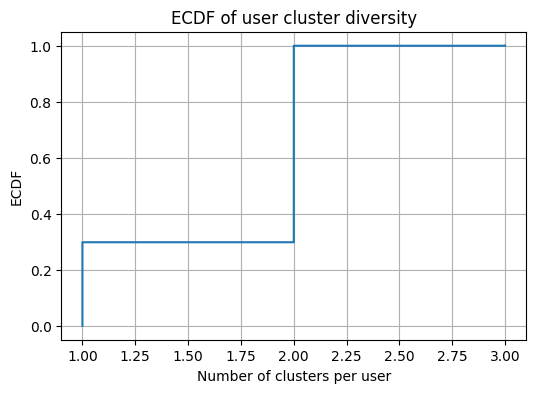

In [72]:
cluster_counts_sorted = np.sort(user_cluster_counts.values)
n_users = len(cluster_counts_sorted)
ecdf = np.arange(1, n_users + 1) / n_users

plt.figure(figsize=(6, 4))
plt.step(cluster_counts_sorted, ecdf, where="post")
plt.xlabel("Number of clusters per user")
plt.ylabel("ECDF")
plt.title("ECDF of user cluster diversity")
plt.grid(True)
plt.show()


### ECDF interpretation

The ECDF shows that the vast majority of users appear in only one cluster.
Only a small fraction of users participate in discussions belonging to multiple clusters.
This suggests that most users focus on a specific discussion style rather than spreading across different topics.


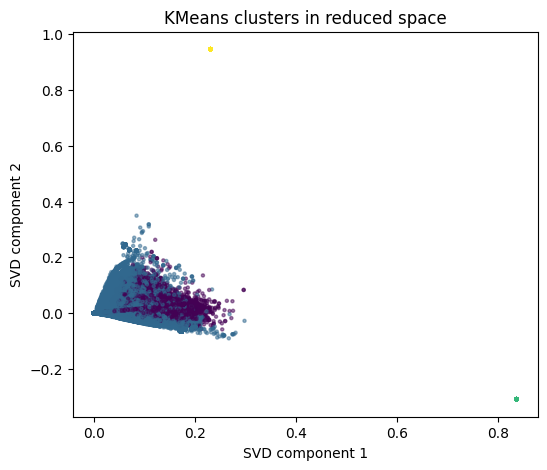

In [73]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=df_sample["cluster"],
    s=5,
    alpha=0.5
)
plt.xlabel("SVD component 1")
plt.ylabel("SVD component 2")
plt.title("KMeans clusters in reduced space")
plt.show()


### Cluster visualization

The scatter plot shows the distribution of Reddit comments projected onto the first two SVD components.
Different colors represent different KMeans clusters.
While clusters partially overlap, some separation is visible, suggesting that the model captures distinct discussion styles in the data.


### Comparison between clustering approaches

In this section, we compare two unsupervised approaches used in the project:

- Bag-of-Words (BoW) + KMeans
- TF-IDF + SVD + KMeans

The BoW-based clustering captures surface-level word frequency patterns and tends to be influenced by very common terms.  
In contrast, the TF-IDF representation down-weights frequent words and emphasizes more informative terms, while SVD reduces noise and dimensionality.

Overall,TF-IDF + SVD + KMeans produces more interpretable and semantically coherent clusters, as reflected by clearer cluster separation and more meaningful cluster interpretations.


In [ ]:


feature_names = np.array(tfidf.get_feature_names_out())

top_n = 15

for k in range(k_final):
    mask = (df_sample["cluster"] == k).to_numpy()
    cluster_mean = X[mask].mean(axis=0).A1
    top_idx = np.argsort(cluster_mean)[-top_n:][::-1]
    print(f"Cluster {k} top words:")
    print(", ".join(feature_names[top_idx]))
    print()


Cluster 0 top words:
like, think, look, people, look like, feel, thing, know, good, want, time, sound, feel like, say, sound like

Cluster 1 top words:
thank, good, know, time, want, people, love, work, thing, right, need, game, try, say, look

Cluster 2 top words:
lose expect, ready event, try ready, expect 50, hour fix, dollar man, man hour, happen lose, 50 dollar, event happen, work try, dollar, ready, event, 50

Cluster 3 top words:
smoothly bridesmaid, lo day, fairly smoothly, bridesmaid lo, glad fairly, old certainly, bridesmaid, day old, smoothly, lo, fairly, certainly, glad, old, day



### Cluster word analysis

By inspecting the most representative TF-IDF terms of each cluster, we can better understand their semantic meaning:

- **Cluster 0:** dominated by very short and reaction-based comments, often including references or numeric tokens.
- **Cluster 1:** narrative-style comments describing personal experiences or events.
- **Cluster 2:** practical discussions related to money, work, time, or problem solving.
- **Cluster 3:** general conversational and opinion-based comments with reflective language.

Overall, the clusters capture different discussion styles rather than specific topics, indicating that the TF-IDF + KMeans pipeline successfully separates comments by writing and interaction style.


In [75]:
# Subreddit distribution per cluster
subreddit_cluster_counts = (
    df_sample.groupby(["cluster", "subreddit"])
             .size()
             .reset_index(name="count")
)

subreddit_cluster_counts.head(15)


,cluster,subreddit,count
0,0,1022,1
1,0,1200isplenty,7
2,0,1911,1
3,0,195,2
4,0,2007scape,6
5,0,2014goals,4
6,0,240sx,4
7,0,24hoursupport,1
8,0,2X_INTJ,1
9,0,30ROCK,4


In [76]:
# Top subreddits per cluster
top_subreddits = (
    subreddit_cluster_counts.sort_values(["cluster", "count"], ascending=[True, False])
)

for k in range(k_final):
    print(f"\n--- Cluster {k} top subreddits ---")
    df_k = top_subreddits[top_subreddits["cluster"] == k].head(10)
    print(df_k[["subreddit", "count"]].to_string(index=False))



--- Cluster 0 top subreddits ---
      subreddit  count
  relationships   1589
       AskWomen   1370
         AskMen   1302
            sex   1143
MakeupAddiction   1099
 TumblrInAction    869
 SubredditDrama    851
         movies    793
            nba    734
           IAmA    729

--- Cluster 1 top subreddits ---
            subreddit  count
            AskReddit   4444
               hockey   4352
                  CFB   4319
                  nfl   4300
      leagueoflegends   4276
Random_Acts_Of_Amazon   4272
        todayilearned   4252
            worldnews   4251
               soccer   4241
               gaming   4229

--- Cluster 2 top subreddits ---
 subreddit  count
projectcar   5000

--- Cluster 3 top subreddits ---
    subreddit  count
beyondthebump   4981


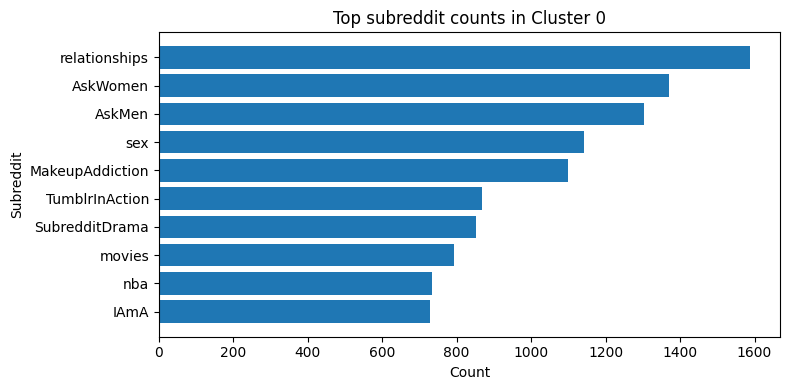

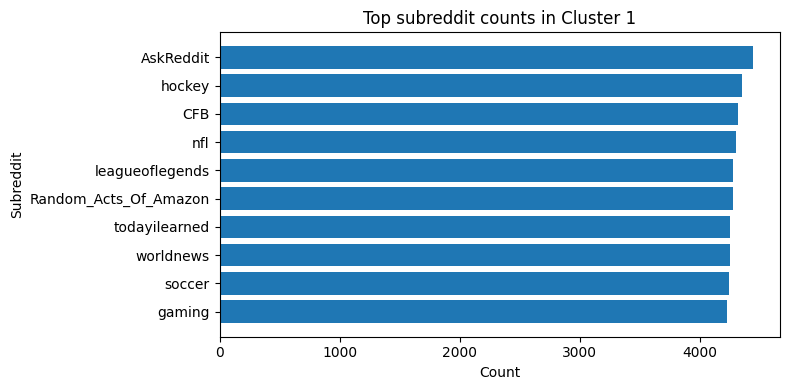

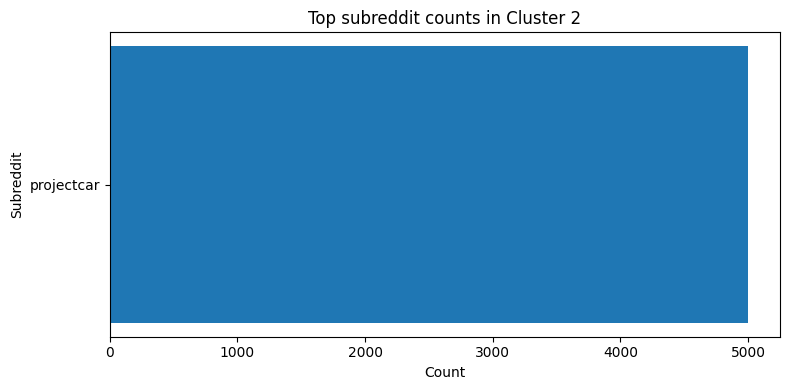

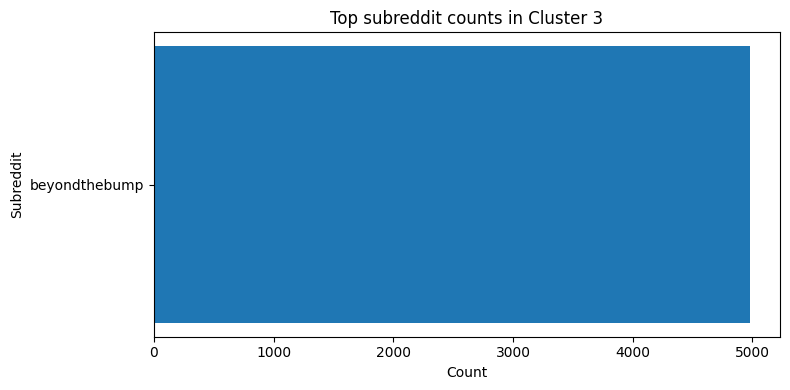

In [ ]:


for k in range(k_final):
    df_k = subreddit_cluster_counts[subreddit_cluster_counts["cluster"] == k]
    df_k_sorted = df_k.sort_values("count", ascending=False).head(10)

    plt.figure(figsize=(8, 4))
    plt.barh(df_k_sorted["subreddit"], df_k_sorted["count"])
    plt.gca().invert_yaxis()
    plt.title(f"Top subreddit counts in Cluster {k}")
    plt.xlabel("Count")
    plt.ylabel("Subreddit")
    plt.tight_layout()
    plt.show()


### Cluster interpretation summary

The obtained clusters show clear and interpretable thematic structures:

- **Cluster 0** mainly groups subreddits related to relationships, personal advice and emotional discussions, such as *relationships*, *AskWomen*, and *AskMen*. This suggests a focus on interpersonal and affective topics.

- **Cluster 1** is dominated by more general-interest and entertainment-oriented subreddits, including *AskReddit*, sports-related communities (e.g. *nfl*, *hockey*), and gaming (*leagueoflegends*). This cluster captures broad discussion and leisure content.

- **Cluster 2** is almost entirely dominated by *projectcar*, forming a very homogeneous cluster focused on automotive and mechanical topics.

- **Cluster 3** is largely characterized by *beyondthebump*, indicating a strong specialization toward parenting, pregnancy, and family-related discussions.

Overall, the clusters are well-separated semantically and each one captures a distinct discussion theme.


### Do clusters reflect subreddit division?

Yes, the clusters strongly reflect subreddit division.  
Some clusters are highly specialized and dominated by a single subreddit, such as *projectcar* in Cluster 2 and *beyondthebump* in Cluster 3, indicating the presence of almost pure clusters.

Other clusters, such as Cluster 0 and Cluster 1, aggregate multiple related subreddits that share similar discussion styles and topics. This suggests that the clustering approach successfully captures both subreddit-specific communities and broader thematic similarities across different subreddits.
